# Assignment: Visualization
### `! git clone https://github.com/ds3001f25/visualization_assignment.git`
### Do Q1 and Q2.

In [2]:
!git clone https://github.com/cayang17/visualization_assignment.git
%cd visualization_assignment

Cloning into 'visualization_assignment'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 7 (from 1)
Receiving objects: 100% (10/10), 1.88 MiB | 9.02 MiB/s, done.
/content/visualization_assignment


**Q1.** Write your own function to make a kernel density plot.

- The user should pass in a Pandas series or Numpy array.
- The default kernel should be Gaussian, but include the uniform/bump and Epanechnikov as alternatives.
- The default bandwidth should be the Silverman plug-in, but allow the user to specify an alternative.
- You can use Matplotlib or Seaborn's `.lineplot`, but not an existing function that creates kernel density plots.

You will have to make a lot of choices and experiment with getting errors. Embrace the challenge and track your choices in the comments in your code.

Use the pretrail data set from class to show that your function works, and compare it with the Seaborn `kdeplot`.

We covered the Gaussian,
$$
k(z) = \dfrac{1}{\sqrt{2\pi}}e^{-z^2/2}
$$
and uniform
$$
k(z) = \begin{cases}
\frac{1}{2}, & |z| \le 1 \\
0, & |z|>1
\end{cases}
$$
kernels in class, but the Epanechnikov kernel is
$$
k(z) = \begin{cases}
\frac{3}{4} (1-z^2), & |z| \le 1 \\
0, & |z|>1.
\end{cases}
$$

In order to make your code run reasonably quickly, consider using the `pdist` or `cdist` functions from SciPy to make distance calculations for arrays of points. The other leading alternative is to thoughtfully use NumPy's broadcasting features. Writing `for` loops will be slow, but that's fine.

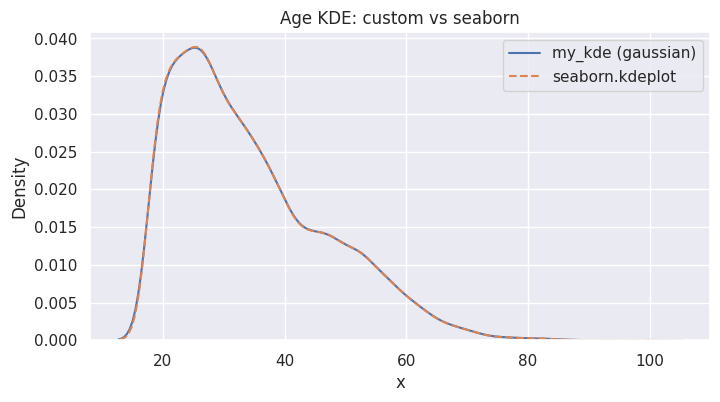

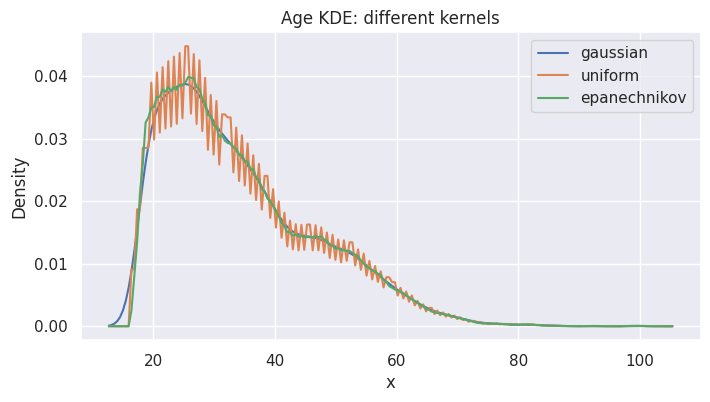

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# helper function
def silverman_bandwidth(x):
    """
    Silverman's plug-in bandwidth:
        h = 1.06 * sigma * n^(-1/5)
    x can be a Pandas Series or NumPy array.
    """
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]  # drop NaNs
    n = len(x)
    if n < 2:
        raise ValueError("Need at least two observations to compute bandwidth.")
    sigma = np.std(x, ddof=1)
    h = 1.06 * sigma * n ** (-1/5)
    return h

# helper function
def kernel_function(z, kernel="gaussian"):
    """
    k(z) for different kernels.
    - gaussian: 1/sqrt(2π) * exp(-z²/2)
    - uniform/bump: 1/2 on |z| <= 1, 0 otherwise
    - epanechnikov: 3/4 * (1 - z²) on |z| <= 1, 0 otherwise
    z can be a scalar or NumPy array.
    """
    z = np.asarray(z, dtype=float)

    if kernel == "gaussian":
        return (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2)

    elif kernel in ["uniform", "bump", "box"]:
        out = np.zeros_like(z, dtype=float)
        mask = np.abs(z) <= 1
        out[mask] = 0.5
        return out

    elif kernel in ["epanechnikov", "epa"]:
        out = np.zeros_like(z, dtype=float)
        mask = np.abs(z) <= 1
        out[mask] = 0.75 * (1 - z[mask]**2)
        return out

    else:
        raise ValueError(f"Unknown kernel '{kernel}'. "
                         "Use 'gaussian', 'uniform', or 'epanechnikov'.")

def my_kde(x,
           kernel="gaussian",
           bandwidth=None,
           grid_size=200,
           cut=3,
           ax=None,
           **plot_kwargs):
    """
    Simple 1D kernel density estimator and plotter.

    Parameters
    ----------
    x : array (1-D data)
    kernel : {'gaussian','uniform','epanechnikov'}
        Choice of kernel.
    bandwidth : float or None
        If None, use Silverman's plug-in bandwidth.
    grid_size : int
        Number of points in the evaluation grid.
    cut : float
        How many bandwidths to extend beyond min/max of the data.
    ax : matplotlib.axes.Axes or None
        Axis to draw on. If None, a new figure/axis is created.
    plot_kwargs : dict
        Extra keyword args passed to seaborn.lineplot (e.g., label, linestyle).

    Returns
    -------
    grid : np.ndarray
        Points where the density is evaluated.
    density : np.ndarray
        Estimated density at each grid point.
    """
    # 1. clean and convert x
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    n = len(x)
    if n == 0:
        raise ValueError("Input x has no non-missing values.")

    # 2) bandwidth: use Silverman's rule if not supplied
    if bandwidth is None:
        bandwidth = silverman_bandwidth(x)

    # 3) build grid: extend min/max by a few bandwidths so tails show up
    x_min, x_max = x.min(), x.max()
    padding = cut * bandwidth
    grid = np.linspace(x_min - padding, x_max + padding, grid_size)

    # 4) vectorized computation of KDE:
    z = (grid[None, :] - x[:, None]) / bandwidth      # shape: (n, grid_size)
    k_vals = kernel_function(z, kernel=kernel)        # same shape

    # average across observations
    density = k_vals.mean(axis=0) / bandwidth         # shape: (grid_size,)

    # 5) plot
    if ax is None:
        fig, ax = plt.subplots()

    sns.lineplot(x=grid, y=density, ax=ax, **plot_kwargs)
    ax.set_ylabel("Density")
    ax.set_xlabel("x")
    ax.set_title(f"KDE ({kernel}, h={bandwidth:.3f})")

    return grid, density


# Use the same pretrial data set from class
pretrial = pd.read_csv("./data/pretrial_data.csv")

# pick a numeric variable, e.g. age
age = pretrial["age"]

fig, ax = plt.subplots(figsize=(8, 4))

# Our KDE
my_kde(age, kernel="gaussian", ax=ax, label="my_kde (gaussian)")

# Seaborn's built-in KDE
sns.kdeplot(x=age, ax=ax, label="seaborn.kdeplot", linestyle="--")

ax.set_title("Age KDE: custom vs seaborn")
ax.legend()
plt.show()

# compare kernels on the same variable
fig, ax = plt.subplots(figsize=(8, 4))
for kern in ["gaussian", "uniform", "epanechnikov"]:
    my_kde(age, kernel=kern, ax=ax, label=kern)
ax.set_title("Age KDE: different kernels")
ax.legend()
plt.show()

**Q2.** This question provides some practice doing exploratory data analysis and visualization.

The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `./data/college_completion.csv` data with Pandas.
2. What are are the dimensions of the data? How many observations are there? What are the variables included? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see.
4. For `grad_100_value`, create a histogram, kernel density plot, boxplot, and statistical description.
5. For `grad_100_value`, create a grouped kernel density plot by `control` and by `level`. Describe what you see. Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `grad_100_value` by `level` and `control`. Which institutions appear to have the best graduation rates?
6. Create a new variable, `df['levelXcontrol']=df['level']+', '+df['control']` that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?
7. Make a kernel density plot of `aid_value`. Now group your graph by `level` and `control`. What explains the shape of the graph? Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `aid_value` by `level` and `control`.
8. Make a scatterplot of `grad_100_value` by `aid_value`. Describe what you see. Now make the same plot, grouping by `level` and then `control`. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?

Dimensions (rows, columns): (3798, 63)

Column dtypes:
index                int64
unitid               int64
chronname           object
city                object
state               object
                    ...   
state_sector_ct      int64
carnegie_ct          int64
counted_pct         object
nicknames           object
cohort_size        float64
Length: 63, dtype: object

First five rows:


,index,unitid,chronname,city,state,level,control,basic,hbcu,flagship,...,vsa_grad_after6_transfer,vsa_grad_elsewhere_after6_transfer,vsa_enroll_after6_transfer,vsa_enroll_elsewhere_after6_transfer,similar,state_sector_ct,carnegie_ct,counted_pct,nicknames,cohort_size
0,0,100654,Alabama A&M University,Normal,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,36.4,5.6,17.2,11.1,232937|100724|405997|113607|139533|144005|2285...,13,386,99.7|07,NaN,882.0
1,1,100663,University of Alabama at Birmingham,Birmingham,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,NaN,NaN,NaN,NaN,196060|180461|201885|145600|209542|236939|1268...,13,106,56.0|07,UAB,1376.0
2,2,100690,Amridge University,Montgomery,Alabama,4-year,Private not-for-profit,Baccalaureate Colleges--Arts & Sciences,NaN,NaN,...,NaN,NaN,NaN,NaN,217925|441511|205124|247825|197647|221856|1353...,16,252,100.0|07,NaN,3.0
3,3,100706,University of Alabama at Huntsville,Huntsville,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,0.0,0.0,0.0,0.0,232186|133881|196103|196413|207388|171128|1900...,13,106,43.1|07,UAH,759.0
4,4,100724,Alabama State University,Montgomery,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,NaN,NaN,NaN,NaN,100654|232937|242617|243197|144005|241739|2354...,13,386,88.0|07,ASU,1351.0



Counts of institutions by control and level:


level,2-year,4-year
control,,
Private for-profit,465,527
Private not-for-profit,68,1180
Public,926,632



Row proportions of institutions by control and level:


level,2-year,4-year
control,,
Private for-profit,0.468750,0.531250
Private not-for-profit,0.054487,0.945513
Public,0.594352,0.405648


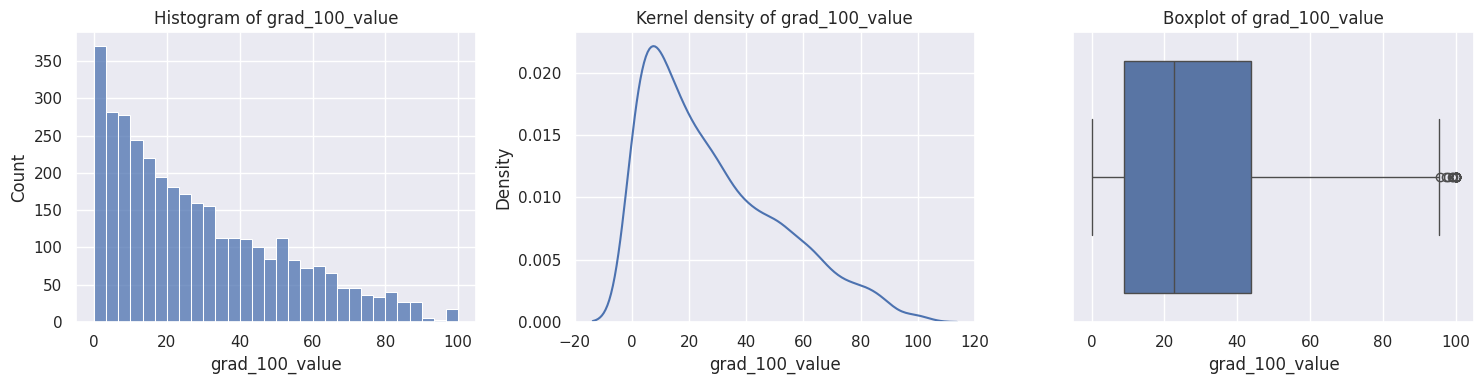


Summary statistics for grad_100_value:
count    3467.000000
mean       28.364465
std        23.312730
min         0.000000
25%         9.000000
50%        22.500000
75%        43.650000
max       100.000000
Name: grad_100_value, dtype: float64


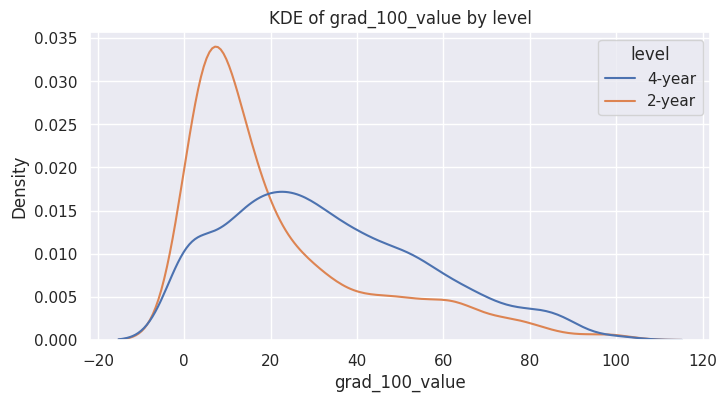

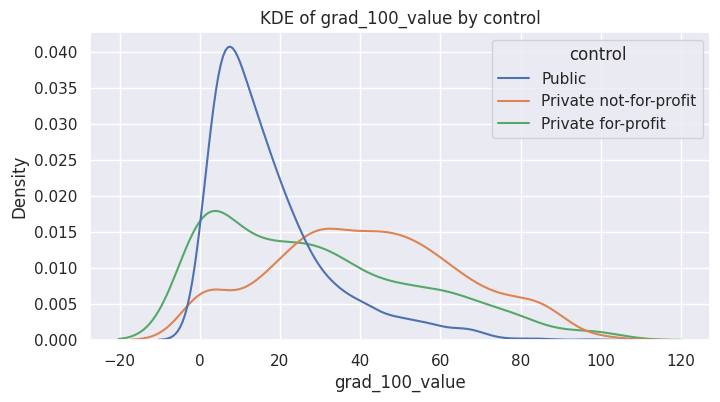

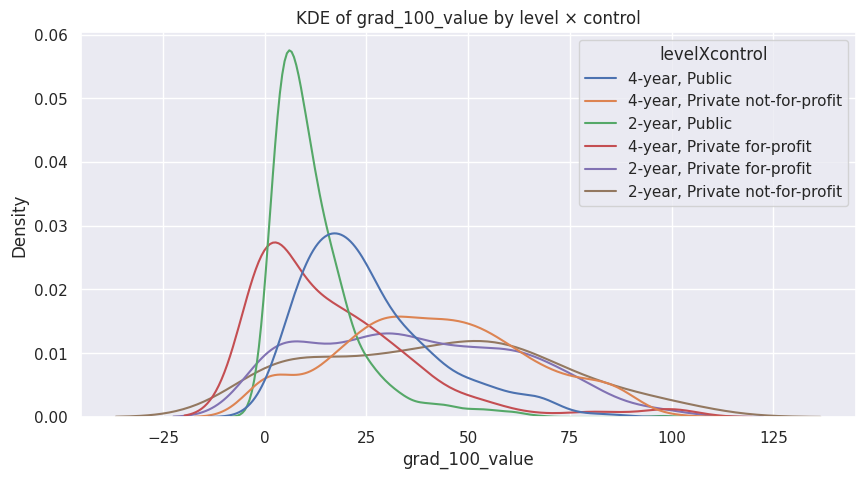

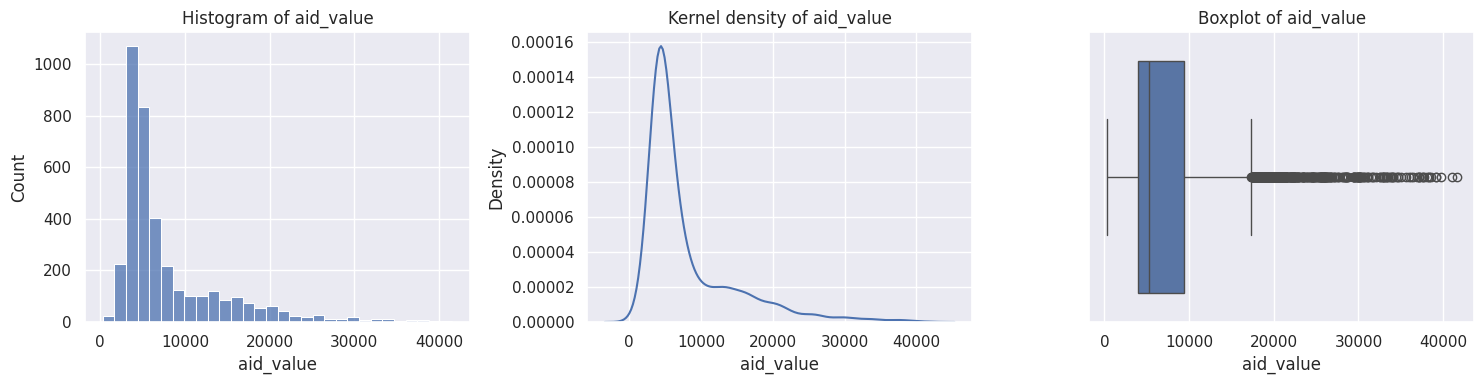


Summary statistics for aid_value:
count     3797.000000
mean      7960.445878
std       6419.658196
min        294.000000
25%       4018.000000
50%       5207.000000
75%       9343.000000
max      41580.000000
Name: aid_value, dtype: float64

Summary statistics for aid_value by level and control:
                                count          mean          std     min  \
level  control                                                             
2-year Private for-profit       464.0   4559.681034  1286.688269   294.0   
       Private not-for-profit    68.0   5128.058824  2590.449946   934.0   
       Public                   926.0   4126.199784  1260.271382   881.0   
4-year Private for-profit       527.0   4696.062619  1489.410020  1580.0   
       Private not-for-profit  1180.0  14702.401695  7649.775203   902.0   
       Public                   632.0   6514.071203  2353.716693  2232.0   

                                   25%      50%       75%      max  
level  control         

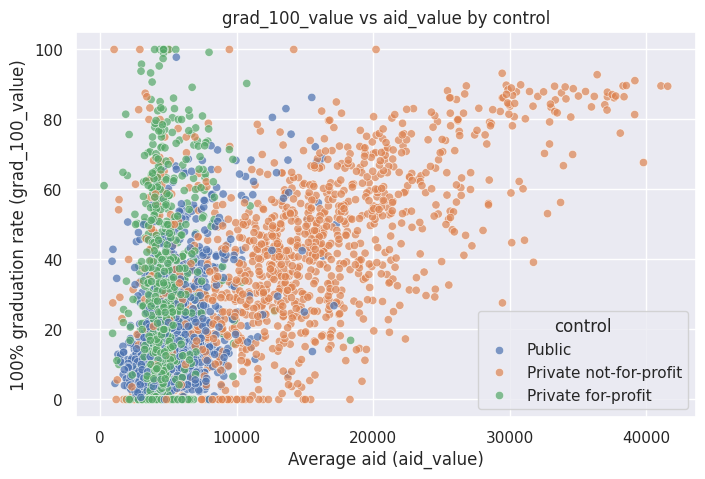

In [6]:
# 1)
df = pd.read_csv("./data/college_completion.csv")

# 2)
print("Dimensions (rows, columns):", df.shape)
print("\nColumn dtypes:")
print(df.dtypes)

print("\nFirst five rows:")
display(df.head())

# 3)
ct_counts = pd.crosstab(df["control"], df["level"])
ct_props = pd.crosstab(df["control"], df["level"], normalize="index")

print("\nCounts of institutions by control and level:")
display(ct_counts)

print("\nRow proportions of institutions by control and level:")
display(ct_props)

# 4)
grad = df["grad_100_value"].dropna()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram
sns.histplot(grad, bins=30, ax=axes[0])
axes[0].set_title("Histogram of grad_100_value")
axes[0].set_xlabel("grad_100_value")

# KDE
sns.kdeplot(x=grad, ax=axes[1])
axes[1].set_title("Kernel density of grad_100_value")
axes[1].set_xlabel("grad_100_value")

# Boxplot
sns.boxplot(x=grad, ax=axes[2])
axes[2].set_title("Boxplot of grad_100_value")
axes[2].set_xlabel("grad_100_value")

plt.tight_layout()
plt.show()

print("\nSummary statistics for grad_100_value:")
print(grad.describe())

# 5)

# by level
fig, ax = plt.subplots(figsize=(8, 4))
sns.kdeplot(data=df, x="grad_100_value", hue="level",
            common_norm=False, ax=ax)
ax.set_title("KDE of grad_100_value by level")
ax.set_xlabel("grad_100_value")
plt.show()

# by control
fig, ax = plt.subplots(figsize=(8, 4))
sns.kdeplot(data=df, x="grad_100_value", hue="control",
            common_norm=False, ax=ax)
ax.set_title("KDE of grad_100_value by control")
ax.set_xlabel("grad_100_value")
plt.show()

# 6)
df["levelXcontrol"] = df["level"] + ", " + df["control"]

fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(data=df, x="grad_100_value", hue="levelXcontrol",
            common_norm=False, ax=ax)
ax.set_title("KDE of grad_100_value by level × control")
ax.set_xlabel("grad_100_value")
plt.show()

# 7)
aid = df["aid_value"].dropna()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram
sns.histplot(aid, bins=30, ax=axes[0])
axes[0].set_title("Histogram of aid_value")
axes[0].set_xlabel("aid_value")

# KDE
sns.kdeplot(x=aid, ax=axes[1])
axes[1].set_title("Kernel density of aid_value")
axes[1].set_xlabel("aid_value")

# Boxplot
sns.boxplot(x=aid, ax=axes[2])
axes[2].set_title("Boxplot of aid_value")
axes[2].set_xlabel("aid_value")

plt.tight_layout()
plt.show()

print("\nSummary statistics for aid_value:")
print(aid.describe())

print("\nSummary statistics for aid_value by level and control:")
print(df.groupby(["level", "control"])["aid_value"].describe())

# 8)
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df,
                x="aid_value",
                y="grad_100_value",
                hue="control",
                alpha=0.7)
ax.set_title("grad_100_value vs aid_value by control")
ax.set_xlabel("Average aid (aid_value)")
ax.set_ylabel("100% graduation rate (grad_100_value)")
plt.show()
